In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

from distributions import GaussianMixtureND
from hmc import hmc_nd


def plot_contour_and_samples_for_two_dims(gmnd, samples, dim1, dim2, x_range, y_range, resolution=100):
    """
    Args:
    - gmnd: An instance of GaussianMixtureND.
    - samples: An array of sampled points from HMC.
    - dim1: The first dimension to plot.
    - dim2: The second dimension to plot.
    - x_range: A tuple specifying the range for the first dimension.
    - y_range: A tuple specifying the range for the second dimension.
    - resolution: The number of points along each axis.
    """
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros(X.shape)
    
    for i in range(resolution):
        for j in range(resolution):
            # Directly use the marginalized_pdf method for the specified dimensions
            Z[i, j] = gmnd.marginalized_pdf([X[i, j], Y[i, j]], [dim1, dim2])
    
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
    plt.colorbar(cp)
    plt.title(f'Contour Plot and HMC Samples\nDimensions {dim1} and {dim2}')
    plt.xlabel(f'Dimension {dim1}')
    plt.ylabel(f'Dimension {dim2}')
    
    sample_points_dim1 = samples[:, dim1]
    sample_points_dim2 = samples[:, dim2]
    plt.scatter(sample_points_dim1, sample_points_dim2, color='orange', s=5, alpha=0.6, label='HMC Samples')
    plt.legend()
    
    plt.show()

def create_correlated_covariance_matrix(dimensions, correlation_coefficient):

    cov_matrix = np.eye(dimensions)
    for i in range(dimensions-1):
        cov_matrix[i, i+1] = cov_matrix[i+1, i] = correlation_coefficient
    return cov_matrix




Current iteration: 0


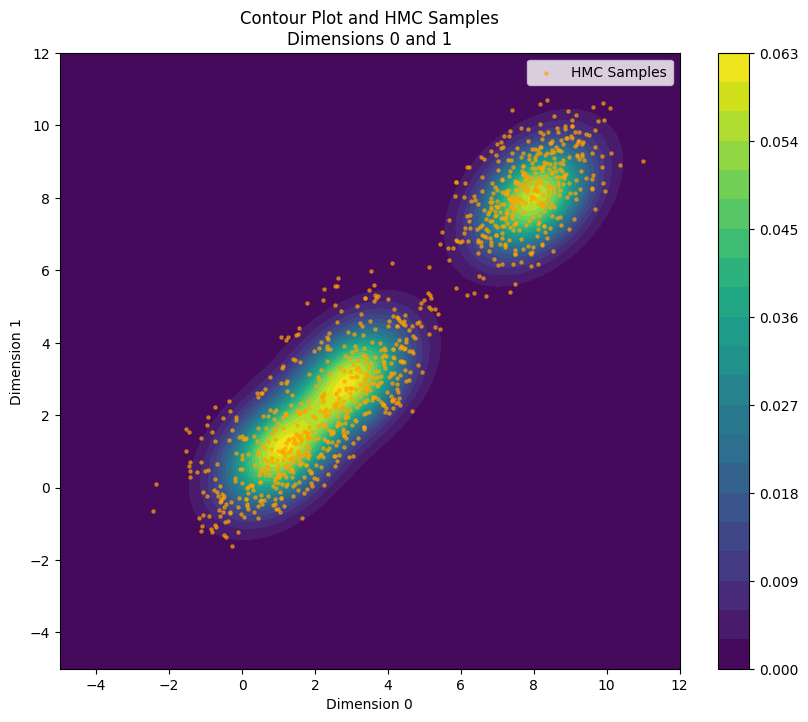

In [2]:

N = 2
correlation_coefficient = 0.4  # Example correlation coefficient

mus = [np.zeros(N) + 1, np.zeros(N) + 3, np.zeros(N) + 8]
sigmas = [create_correlated_covariance_matrix(N, correlation_coefficient) for _ in range(3)]
gmnd = GaussianMixtureND(mus, sigmas)

# Initial state for the HMC sampling
initial_state = np.zeros(N)

# Run HMC sampling
samples, trace_x_all, trace_v_all, accept_or_not = hmc_nd(
    target_distribution=gmnd,
    initial_state=initial_state,
    iterations=1000,  # Adjust based on your computational budget
    step_size=0.5,
    n_steps=10
)

# Assuming `samples` is a numpy array of sampled points
# Convert list of samples to a numpy array for easy indexing
samples_array = np.array(samples[1:])  # Exclude the initial state if it's included
plot_contour_and_samples_for_two_dims(gmnd, samples_array, 0, 1, (-5, 12), (-5, 12))

In [ ]:
# Some code to get acceptance rate as a function of step size. 

initial_state = np.zeros(N)

# -- 
step_sizes = [0.1, 0.5, 1.0, 2.0]
repeats = 10  # Number of re runs

overall_acceptance_rates = {step_size: [] for step_size in step_sizes}
overall_times = {step_size: [] for step_size in step_sizes}  
for step_size in step_sizes:
    print(f"Running simulations for step size {step_size}")
    for _ in range(repeats):
        start_time = time.time()  

        _, _, _, accept_or_not = hmc_nd(
            target_distribution=gmnd,
            initial_state=initial_state,
            iterations=10000, 
            step_size=step_size,
            n_steps=10,
            integrator='splitstep' 
        )

        end_time = time.time()  
        elapsed_time = end_time - start_time
        overall_times[step_size].append(elapsed_time) 

        acceptance_rate = np.mean(accept_or_not)
        overall_acceptance_rates[step_size].append(acceptance_rate)

for step_size in step_sizes:
    rates = overall_acceptance_rates[step_size]
    times = overall_times[step_size]
    mean_rate = np.mean(rates)
    std_dev_rate = np.std(rates)
    mean_time = np.mean(times)
    std_dev_time = np.std(times)
    print(f"Step size {step_size}: Mean acceptance rate = {mean_rate:.3f}, Std dev = {std_dev_rate:.3f}, Mean time = {mean_time:.3f}s, Std dev time = {std_dev_time:.3f}s")


splitstep_ar = mean_rate
splitstep_ar_std = std_dev_rate
